Eigenvalue MC code

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import os

from models import globalvariables as GV
from models import geometry_models as geo_m
from models import physic_model as phy_m
from models import material_model as mat_m
from models import statistic_model as stat_m

from controllers import geometry_controller as geo_c
from controllers import physics_controller as phy_c
from controllers import material_controller as mat_c
from controllers import statistic_controller as stat_c

Import data

In [2]:
# Base directory
base_dir = 'cross_sections_Janis'

U238_total = np.loadtxt(os.path.join(base_dir, 'U238', 'U238_total.csv'), delimiter=';', skiprows=3)
U238_scattering = np.loadtxt(os.path.join(base_dir, 'U238', 'U238_scattering.csv'), delimiter=';', skiprows=3)
U238_fission = np.loadtxt(os.path.join(base_dir, 'U238', 'U238_fission.csv'), delimiter=';', skiprows=3)
U238_nu = np.loadtxt(os.path.join(base_dir, 'U238', 'U238_nu.csv'), delimiter=';', skiprows=3)

U235_total = np.loadtxt(os.path.join(base_dir, 'U235', 'U235_total.csv'), delimiter=';', skiprows=3)
U235_scattering = np.loadtxt(os.path.join(base_dir, 'U235', 'U235_scattering.csv'), delimiter=';', skiprows=3)
U235_fission = np.loadtxt(os.path.join(base_dir, 'U235', 'U235_fission.csv'), delimiter=';', skiprows=3)
U235_nu = np.loadtxt(os.path.join(base_dir, 'U235', 'U235_nu.csv'), delimiter=';', skiprows=3)

U234_total = np.loadtxt(os.path.join(base_dir, 'U234', 'U234_total.csv'), delimiter=';', skiprows=3)
U234_scattering = np.loadtxt(os.path.join(base_dir, 'U234', 'U234_scattering.csv'), delimiter=';', skiprows=3)
U234_fission = np.loadtxt(os.path.join(base_dir, 'U234', 'U234_fission.csv'), delimiter=';', skiprows=3)
U234_nu = np.loadtxt(os.path.join(base_dir, 'U234', 'U234_nu.csv'), delimiter=';', skiprows=3)

Create isotopes

In [3]:
uranium238 = mat_m.isotope(92,238,4.4984E21,U238_total[:,0],U238_total[:,1],U238_scattering[:,1],U238_fission[:,1],U238_nu[:,1])
uranium235 = mat_m.isotope(92,235,4.4994E22,U235_total[:,0],U235_total[:,1],U235_scattering[:,1],U235_fission[:,1],U235_nu[:,1])
uranium234 = mat_m.isotope(92,234,4.9184E20,U234_total[:,0],U234_total[:,1],U234_scattering[:,1],U234_fission[:,1],U234_nu[:,1])
source = phy_m.source(GV.Nstories,GV.LL,1000,GV.SOURCE_POSITION,1.,'watt')
particle_squeue = []

Create materials

In [4]:
core_list = [uranium238, uranium235, uranium234]
core = mat_m.material(core_list)

Tally creations

In [5]:
distribution = [(core,0,GV.LEnd)]
domain = geo_m.domain(distribution,GV.LL,1000,GV.EE,1000,True)
tally = stat_m.tally(GV.LL,200)
KK = [GV.Kin,GV.Kin]
Keff = KK[-1]

Monte Carlo code

In [6]:
for ii in range(int(GV.Nskip)):
    ww = GV.Nstories/source.tot_generated*Keff
    phy_c.generate_population(source,ww,particle_squeue,domain)
    print(ii)
    Keff = KK[-1]
    Knew = 0
    source.reset_source()
    while len(particle_squeue)>0:
        nn = particle_squeue.pop(0)
        while nn.eof > 0:
            nn.position = phy_c.sample_free_flight(nn,domain)
            if geo_c.is_outofbound(nn,'space'):
                nn.eof = 0
            else:
                Knew += phy_c.implicit_fission(nn,domain,source, Keff)
                # aggiorno i dati della particella dopo l'interazione
                nn.energy = phy_c.sample_energy_stepf(nn,domain)
                nn.direction = geo_m.direction.get_rnd_direction()
                nn.weight = phy_c.new_weight(nn,domain)
                # controllo l'energia
                if geo_c.is_outofbound(nn,'energy') is True:
                    nn.eof = 0
                else:
                    # russian roulette e splitting
                    stat_c.russian_roulette(nn)
                    stat_c.splitting(nn,particle_squeue)
    source.s_entropy()
    stat_c.restart_cycle()
    KK.append(Knew)

0


KeyboardInterrupt: 

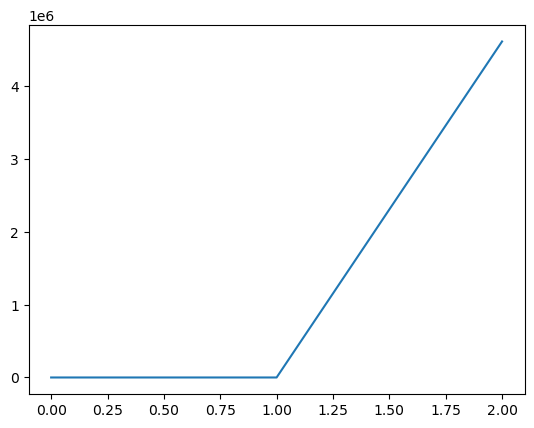

In [7]:
plt.plot(KK)